## Imports and Paths

In [126]:
import os
import random
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# For visualization and tracking
import matplotlib.pyplot as plt

# For progress bars (optional but nice)
from tqdm import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [127]:
base_path = "data/UCI_HAR_Dataset"
save_dir = "saved"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")

In [128]:
X_train = np.loadtxt(os.path.join(train_path, "X_train.txt"))
y_train = np.loadtxt(os.path.join(train_path, "y_train.txt")).astype(int)
subjects_train = np.loadtxt(os.path.join(train_path, "subject_train.txt")).astype(int)

In [129]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train - 1, dtype=torch.long)  # convert 1–6 → 0–5
subjects_train = torch.tensor(subjects_train, dtype=torch.long)

## Data generation

In [130]:
client_data = {}
unique_subjects = subjects_train.unique().tolist()

for sid in unique_subjects:
    # Get indices for this subject
    indices = (subjects_train == sid).nonzero(as_tuple=True)[0]
    x_client = X_train[indices]
    y_client = y_train[indices]
    
    # Normalize locally (per subject)
    mean = x_client.mean(dim=0, keepdim=True)
    std = x_client.std(dim=0, keepdim=True) + 1e-8
    x_client = (x_client - mean) / std
    
    # Store
    client_data[int(sid)] = {"x": x_client, "y": y_client}

In [131]:
print(f"Total clients: {len(client_data)}")
for cid in list(client_data.keys())[:3]:
    print(f"Client {cid}: X {client_data[cid]['x'].shape}, y {client_data[cid]['y'].shape}")

Total clients: 21
Client 1: X torch.Size([347, 561]), y torch.Size([347])
Client 3: X torch.Size([341, 561]), y torch.Size([341])
Client 5: X torch.Size([302, 561]), y torch.Size([302])


# Imp. Classes

#### MLP structure
- uses the structure of 561-256-128-6 with 2 ReLU layers
- uses drop-out to avoid overfitting 

In [132]:
# ========== Cell: MLP model ==========
import torch.nn as nn

class MLPModel(nn.Module):
    def __init__(self, input_dim=561, hidden1=256, hidden2=128, num_classes=6, p_drop=0.4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(hidden2, num_classes)   # logits (no softmax)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

Loads the model to the GPU

In [133]:
model = MLPModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#### Client class
- contains each 1 out of 21 as a client
- they can basically see just their own data which matches the real world privacy concerns

In [134]:
class Client:
    def __init__(self, client_id, data, device, local_epochs=2, batch_size=32, lr=1e-3):
        """
        Each Client represents one subject in the dataset.
        data: {"x": tensor, "y": tensor}
        """
        self.id = client_id
        self.x = data["x"]
        self.y = data["y"]
        self.device = device
        self.local_epochs = local_epochs
        self.batch_size = batch_size
        self.lr = lr

        # Create DataLoader for batching
        dataset = TensorDataset(self.x, self.y)
        self.loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

    def train_local(self, global_model):
        """
        Receives the global model, trains locally, and returns updated weights + sample count.
        """
        # Deep copy to avoid modifying global weights directly
        model = copy.deepcopy(global_model).to(self.device)
        model.train()

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=self.lr)

        for epoch in range(self.local_epochs):
            for xb, yb in self.loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

        # Return updated weights and number of samples
        return model.state_dict(), len(self.x)

#### Server Class
- selects 100*C% models which are then used to do the training and generate the new model
- contains the training loop

In [135]:
class Server:
    def __init__(self, global_model, client_data, device, C=1.0):
        """
        global_model: shared MLP model
        client_data: dictionary {id: {"x":..., "y":...}}
        C: fraction of clients participating per round
        """
        self.global_model = global_model
        self.device = device
        self.C = C

        # Initialize all client objects
        self.clients = [
            Client(cid, data, device)
            for cid, data in client_data.items()
        ]
        self.total_clients = len(self.clients)

    def select_clients(self):
        """Randomly select a fraction C of clients each round."""
        m = max(1, int(self.C * self.total_clients))
        return random.sample(self.clients, m)

    def aggregate(self, client_weights, client_sizes):
        """FedAvg weighted aggregation."""
        global_dict = copy.deepcopy(client_weights[0])
        total_samples = sum(client_sizes)

        for key in global_dict.keys():
            global_dict[key] = sum(
                client_weights[i][key] * (client_sizes[i] / total_samples)
                for i in range(len(client_weights))
            )
        return global_dict

    def evaluate(self, X_test, y_test):
        """Evaluate global model on test set."""
        self.global_model.eval()
        X_test, y_test = X_test.to(self.device), y_test.to(self.device)
        with torch.no_grad():
            preds = self.global_model(X_test)
            acc = (preds.argmax(dim=1) == y_test).float().mean().item()
        return acc

    def train(self, num_rounds, X_test, y_test, save_every=10):
        """Full federated training loop."""
        history = {"round": [], "train_acc": [], "test_acc": []}

        for rnd in range(1, num_rounds + 1):
            selected = self.select_clients()
            client_weights, client_sizes, client_accs = [], [], []

            for client in selected:
                w, n = client.train_local(self.global_model)
                client_weights.append(w)
                client_sizes.append(n)

                # --- compute local training accuracy for this client ---
                model_eval = copy.deepcopy(self.global_model)
                model_eval.load_state_dict(w)
                model_eval.eval()
                with torch.no_grad():
                    preds = model_eval(client.x.to(self.device))
                    acc = (preds.argmax(dim=1) == client.y.to(self.device)).float().mean().item()
                client_accs.append(acc)

            # FedAvg
            new_state = self.aggregate(client_weights, client_sizes)
            self.global_model.load_state_dict(new_state)

            # Aggregate local accuracies
            avg_train_acc = np.mean(client_accs)
            test_acc = self.evaluate(X_test, y_test)
            history["round"].append(rnd)
            history["train_acc"].append(avg_train_acc)
            history["test_acc"].append(test_acc)

            # Logging
            if rnd % 5 == 0:
                print(f"Round {rnd:03d} | Train Acc: {avg_train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")

            if rnd % save_every == 0:
                torch.save(self.global_model.state_dict(), f"saved/model_round_{rnd}.pth")
                print(f"✅ Model checkpoint saved at round {rnd}")

        return history



In [137]:
# ----- Step 1: Load test data -----
X_test = np.loadtxt(os.path.join(test_path, "X_test.txt"))
y_test = np.loadtxt(os.path.join(test_path, "y_test.txt")).astype(int)
subjects_test = np.loadtxt(os.path.join(test_path, "subject_test.txt")).astype(int)

# Convert to torch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test - 1, dtype=torch.long)

In [138]:
mean = X_test.mean(dim=0, keepdim=True)
std = X_test.std(dim=0, keepdim=True) + 1e-8
X_test = (X_test - mean) / std

In [139]:
# ----- Step 2: Initialize Server -----
server = Server(
    global_model=model,
    client_data=client_data,
    device=device,
    C=1.0  # full participation for now
)

In [140]:
# Run training again (shorter test run first if you like)
history = server.train(num_rounds=50, X_test=X_test, y_test=y_test)

Round 005 | Train Acc: 98.39% | Test Acc: 91.08%
Round 010 | Train Acc: 99.03% | Test Acc: 93.11%
✅ Model checkpoint saved at round 10
Round 015 | Train Acc: 99.45% | Test Acc: 93.55%
Round 020 | Train Acc: 99.50% | Test Acc: 93.65%
✅ Model checkpoint saved at round 20
Round 025 | Train Acc: 99.37% | Test Acc: 93.72%
Round 030 | Train Acc: 99.64% | Test Acc: 93.99%
✅ Model checkpoint saved at round 30
Round 035 | Train Acc: 99.60% | Test Acc: 93.89%
Round 040 | Train Acc: 99.67% | Test Acc: 94.06%
✅ Model checkpoint saved at round 40
Round 045 | Train Acc: 99.58% | Test Acc: 93.93%
Round 050 | Train Acc: 99.68% | Test Acc: 93.69%
✅ Model checkpoint saved at round 50


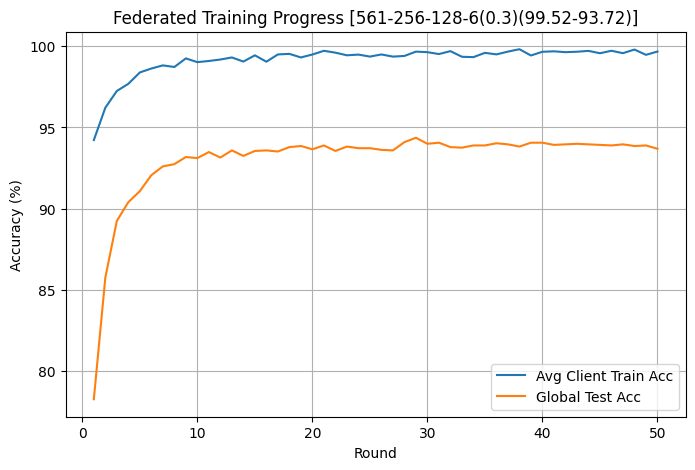

✅ Plot saved successfully at: saved/561-256-128-6(0.3)(99.52-93.72).png


In [141]:
plt.figure(figsize=(8,5))
plt.plot(history["round"], np.array(history["train_acc"]) * 100, label="Avg Client Train Acc")
plt.plot(history["round"], np.array(history["test_acc"]) * 100, label="Global Test Acc")
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("Federated Training Progress [561-256-128-6(0.3)(99.52-93.72)]")
plt.legend()
plt.grid(True)

# Save the plot
save_path = os.path.join(save_dir, "561-256-128-6(0.3)(99.52-93.72).png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Plot saved successfully at: {save_path}")